## DL Sprint
### ResNet50

In [4]:
# !pip install tensorflow pandas keras matplotlib numpy scikit-learn opencv-python

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import cv2
import keras
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


n_epoch = 10
batch_size = 32
image_shape = (374, 500, 3)
base_dir = "/content/drive/MyDrive/ml-project/dl-sprint/spec/dls-train-balanced"

In [7]:
#@title Batch Generator
class DataGenerator(Sequence):

    def __init__(self, X, y, base_dir, batch_size, n_class, shuffle=False):
        self.X = X
        self.y = y
        self.n_class = n_class
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        assert len(self.X) == len(self.y)
        return int(np.ceil(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        X_batch = self.X[index*self.batch_size : (index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size : (index+1)*self.batch_size]

        X = self.__data_generation(X_batch)
        y = keras.utils.to_categorical(y_batch, num_classes=self.n_class)
        return X, y

    def __data_generation(self, X_img):
        X = []
        for file in X_img:
            t = cv2.imread(f"{self.base_dir}/{file}", cv2.COLOR_BGR2RGB)
            X.append(t)
        return np.asarray(X)

In [8]:
#@title Model Creation
resnet50 = tensorflow.keras.applications.resnet50.ResNet50(weights=None, input_shape=image_shape, classes=2)

model = Sequential()
model.add(resnet50)
# model.add(Dense(2, activation="softmax"))

model.build(input_shape=image_shape)
model.summary()

adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2)                 23591810  
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
#@title Data Splitting
df = pd.read_csv("/content/drive/MyDrive/ml-project/dl-sprint/spec/dls-train-balanced.csv")

#   sub sampling
df_m = df.loc[ df["gender"] == "male" ]
df_f = df.loc[ df["gender"] == "female" ]

df_m = df_m.head(2500)
df_f = df_f.head(2500)

df = pd.concat([df_m, df_f])
print(f"Final Dataset size: {len(df)}")

X = df["imgname"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Dataset and Image Loaded")
print("X_train:", len(X_train), "\tX_test:",  len(X_test))
print("y_train:", len(y_train), "\ty_test:",  len(y_test))

Final Dataset size: 5000
Dataset and Image Loaded
X_train: 4000 	X_test: 1000
y_train: 4000 	y_test: 1000


In [10]:
#@title Data Generation
train_gen = DataGenerator(X_train, y_train, base_dir=base_dir, n_class=2, batch_size=batch_size)
test_gen  = DataGenerator(X_test,  y_test,  base_dir=base_dir, n_class=2, batch_size=batch_size)

In [11]:
#@title Model Training
for i in range(n_epoch):
    print("Epoch:", i)
    model.fit(train_gen, verbose=1)
    model.save(f"/content/drive/MyDrive/ml-project/dl-sprint/spec/mel_resnet50_dls_cp_{i}", save_format="h5")

Epoch: 0
125/125 [==============================] - 1308s 10s/step - loss: 0.2739 - accuracy: 0.8827
Epoch: 1
125/125 [==============================] - 147s 1s/step - loss: 0.1706 - accuracy: 0.9380
Epoch: 2
125/125 [==============================] - 147s 1s/step - loss: 0.1485 - accuracy: 0.9460
Epoch: 3
125/125 [==============================] - 146s 1s/step - loss: 0.1402 - accuracy: 0.9457
Epoch: 4
125/125 [==============================] - 146s 1s/step - loss: 0.1357 - accuracy: 0.9480
Epoch: 5
125/125 [==============================] - 147s 1s/step - loss: 0.0861 - accuracy: 0.9663
Epoch: 6
125/125 [==============================] - 147s 1s/step - loss: 0.0725 - accuracy: 0.9732
Epoch: 7
125/125 [==============================] - 146s 1s/step - loss: 0.0510 - accuracy: 0.9800
Epoch: 8
125/125 [==============================] - 147s 1s/step - loss: 0.0553 - accuracy: 0.9808
Epoch: 9
125/125 [==============================] - 147s 1s/step - loss: 0.0392 - accuracy: 0.9877


32/32 [==============================] - 321s 10s/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       482
           1       0.94      0.98      0.96       518

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



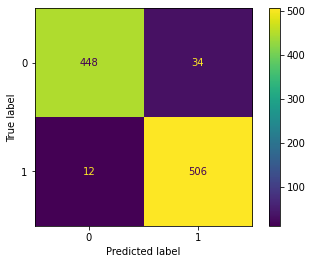

In [12]:
#@title Model Prediction
y_pred = model.predict(test_gen)
y_pred_arg = np.argmax(y_pred, axis=1)

report = classification_report(y_true=y_test, y_pred=y_pred_arg)
print(report)

conf_mat = confusion_matrix(y_test, y_pred_arg)
conf_dis = ConfusionMatrixDisplay(conf_mat)
conf_dis.plot()
plt.show()